In [1]:
!pip install qiskit qiskit_aer
!pip install qiskit-ibm-runtime --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.9 MB/s eta 0:00:00


In [2]:
%matplotlib inline

In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
import numpy as np

Secret string s = 1011
     ┌───┐          ┌───┐          ┌─┐           
q_0: ┤ H ├───────■──┤ H ├──────────┤M├───────────
     ├───┤┌───┐  │  └┬─┬┘          └╥┘           
q_1: ┤ H ├┤ H ├──┼───┤M├────────────╫────────────
     ├───┤└───┘  │   └╥┘      ┌───┐ ║      ┌─┐   
q_2: ┤ H ├───────┼────╫────■──┤ H ├─╫──────┤M├───
     ├───┤       │    ║    │  └───┘ ║ ┌───┐└╥┘┌─┐
q_3: ┤ H ├───────┼────╫────┼────■───╫─┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐  ║  ┌─┴─┐┌─┴─┐ ║ └───┘ ║ └╥┘
q_4: ┤ X ├┤ H ├┤ X ├──╫──┤ X ├┤ X ├─╫───────╫──╫─
     └───┘└───┘└───┘  ║  └───┘└───┘ ║       ║  ║ 
c: 4/═════════════════╩═════════════╩═══════╩══╩═
                      1             0       2  3 
Counts: {'1101': 1024}


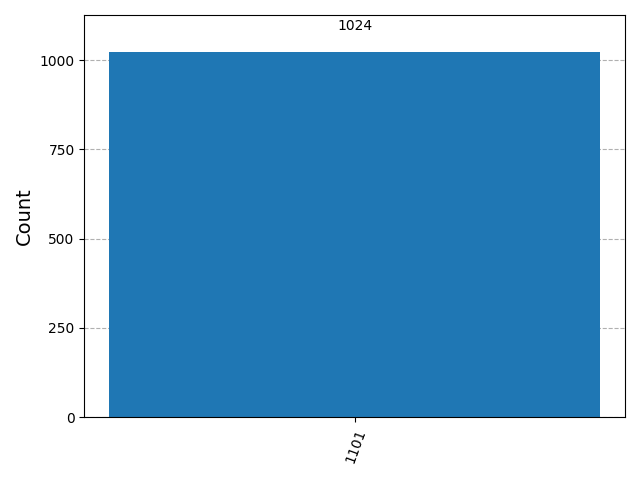

Most frequent measured bitstring (input register): 1101
⚠️ Measured string differs from s (noise or error).


In [4]:
# Bernstein–Vazirani Algorithm using Qiskit 2.x
def bv_oracle(qc, inputs, ancilla, s):
    """Implements oracle for f(x) = s · x (no constant b)."""
    for i, bit in enumerate(s):
        if bit == '1':
            qc.cx(inputs[i], ancilla)

def bernstein_vazirani_circuit(s):
    n = len(s)
    qreg = QuantumRegister(n + 1, 'q')
    creg = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(qreg, creg)
    inputs = list(range(n))
    ancilla = n

    qc.x(ancilla)
    qc.h(qreg)
    bv_oracle(qc, inputs, ancilla, s)
    for q in inputs:
        qc.h(q)
    qc.measure(inputs, creg)
    return qc

def run_bv(qc, shots=1024):
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    job = sim.run(tqc, shots=shots)
    result = job.result()
    counts = result.get_counts()
    print('Counts:', counts)
    fig = plot_histogram(counts)
    fig.savefig("bv_hist.png")
    plt.close(fig)
    display(Image("bv_hist.png"))

    most = max(counts, key=counts.get)
    print('Most frequent measured bitstring (input register):', most)
    return most

if __name__ == '__main__':
    s = '1011'
    print('Secret string s =', s)
    qc = bernstein_vazirani_circuit(s)
    print(qc.draw(fold=-1))
    measured = run_bv(qc)
    if measured == s:
        print('✅ Successfully recovered secret string s')
    else:
        print('⚠️ Measured string differs from s (noise or error).')


Secret string s = 11010
     ┌───┐          ┌───┐             ┌─┐           
q_0: ┤ H ├───────■──┤ H ├─────────────┤M├───────────
     ├───┤       │  └───┘        ┌───┐└╥┘     ┌─┐   
q_1: ┤ H ├───────┼────────────■──┤ H ├─╫──────┤M├───
     ├───┤┌───┐  │   ┌─┐      │  └───┘ ║      └╥┘   
q_2: ┤ H ├┤ H ├──┼───┤M├──────┼────────╫───────╫────
     ├───┤└───┘  │   └╥┘      │        ║ ┌───┐ ║ ┌─┐
q_3: ┤ H ├───────┼────╫───────┼────■───╫─┤ H ├─╫─┤M├
     ├───┤┌───┐  │    ║  ┌─┐  │    │   ║ └───┘ ║ └╥┘
q_4: ┤ H ├┤ H ├──┼────╫──┤M├──┼────┼───╫───────╫──╫─
     ├───┤├───┤┌─┴─┐  ║  └╥┘┌─┴─┐┌─┴─┐ ║       ║  ║ 
q_5: ┤ X ├┤ H ├┤ X ├──╫───╫─┤ X ├┤ X ├─╫───────╫──╫─
     └───┘└───┘└───┘  ║   ║ └───┘└───┘ ║       ║  ║ 
c: 5/═════════════════╩═══╩════════════╩═══════╩══╩═
                      2   4            0       1  3 
Counts: {'01011': 1024}


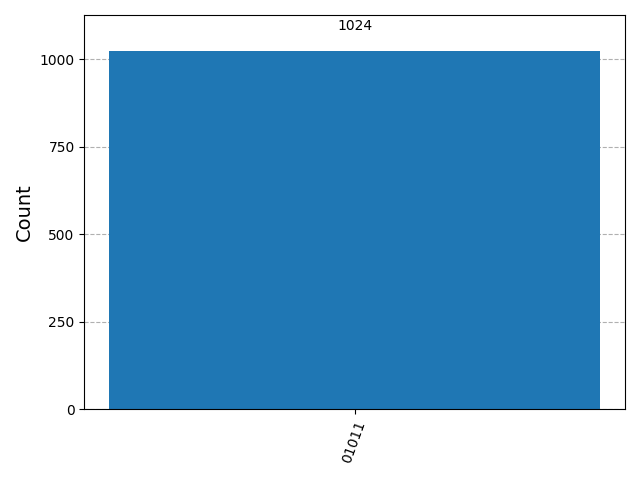

Most frequent measured bitstring (input register): 01011
Successfully recovered secret string s


In [5]:
s = '11010' # altered string
print('Secret string s =', s)
qc = bernstein_vazirani_circuit(s)
print(qc.draw(fold=-1))
measured = run_bv(qc)
# verification
if measured[::-1] == s:
    print('Successfully recovered secret string s')
else:
    print('Measured string differs from s (noise or error).')


Secret string s = 1011 and constant bit b = 1
     ┌───┐          ┌───┐          ┌─┐                               
q_0: ┤ H ├───────■──┤ H ├──────────┤M├──────────■────────────────────
     ├───┤┌───┐  │  └┬─┬┘          └╥┘          │                    
q_1: ┤ H ├┤ H ├──┼───┤M├────────────╫───────────┼────────────────────
     ├───┤└───┘  │   └╥┘      ┌───┐ ║      ┌─┐  │                    
q_2: ┤ H ├───────┼────╫────■──┤ H ├─╫──────┤M├──┼───────■────────────
     ├───┤       │    ║    │  └───┘ ║ ┌───┐└╥┘  │  ┌─┐  │            
q_3: ┤ H ├───────┼────╫────┼────■───╫─┤ H ├─╫───┼──┤M├──┼────■───────
     ├───┤┌───┐┌─┴─┐  ║  ┌─┴─┐┌─┴─┐ ║ └───┘ ║ ┌─┴─┐└╥┘┌─┴─┐┌─┴─┐┌───┐
q_4: ┤ X ├┤ H ├┤ X ├──╫──┤ X ├┤ X ├─╫───────╫─┤ X ├─╫─┤ X ├┤ X ├┤ X ├
     └───┘└───┘└───┘  ║  └───┘└───┘ ║       ║ └───┘ ║ └───┘└───┘└───┘
c: 4/═════════════════╩═════════════╩═══════╩═══════╩════════════════
                      1             0       2       3                
Counts: {'1101': 1024}


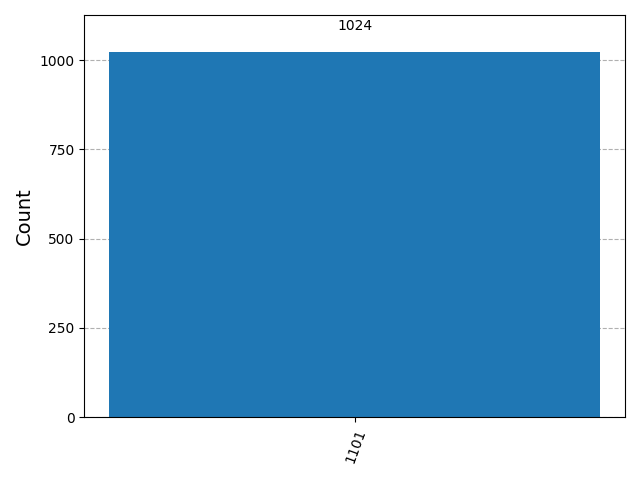

Most frequent measured bitstring (input register): 1101


In [6]:
def bv_oracle_with_b(qc, inputs, ancilla, s, b):
    for i, bit in enumerate(s):
        if bit == '1':
            qc.cx(inputs[i], ancilla)
    if b == '1':
        qc.x(ancilla)

s = '1011'
b = '1' # additional constant bit
print('Secret string s =', s, 'and constant bit b =', b)
qc = bernstein_vazirani_circuit(s)
bv_oracle_with_b(qc, list(range(len(s))), len(s), s, b)
print(qc.draw(fold=-1))
measured = run_bv(qc)


In [7]:
# Set up IBM runtime

from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token="k34-0aexb0tlfWH92G9O0NJPan5KF4RPJJknzCPsT_-W",
    overwrite=True
)

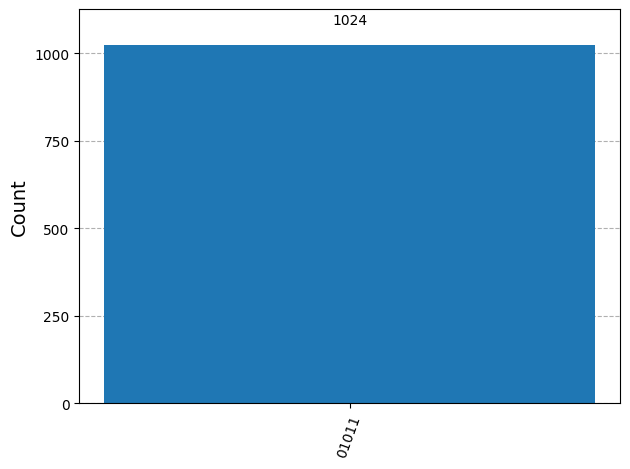

Simulator counts: {'01011': 1024}


qiskit_runtime_service.__init__:WARNING:2025-11-06 15:06:26,223: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-11-06 15:06:26,780: Loading instance: open-instance, plan: open
qiskit_runtime_service.backends:WARNING:2025-11-06 15:06:28,840: Using instance: open-instance, plan: open


Running on backend: ibm_fez


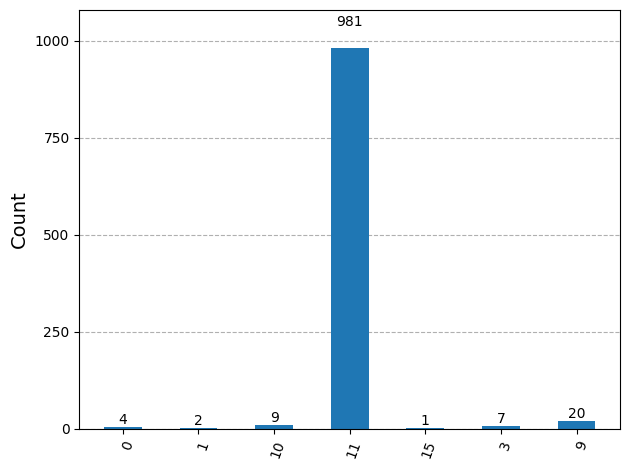

Real device counts: {'11': 981, '9': 20, '3': 7, '0': 4, '10': 9, '15': 1, '1': 2}


In [8]:
s = '11010'
qc = bernstein_vazirani_circuit(s)

sim = AerSimulator()
tqc_sim = transpile(qc, sim)
job_sim = sim.run(tqc_sim, shots=1024)
res_sim = job_sim.result()
counts_sim = res_sim.get_counts()
display(plot_histogram(counts_sim))
print("Simulator counts:", counts_sim)

# --- Real IBM Quantum Execution ---
service = QiskitRuntimeService(channel="ibm_quantum_platform")
backend = service.least_busy(operational=True, simulator=False)
print("Running on backend:", backend.name)

tqc_real = transpile(qc, backend=backend, optimization_level=1, translation_method="translator")
sampler = SamplerV2(backend)
job_real = sampler.run([tqc_real], shots=1024)
res_real = job_real.result()

from qiskit.primitives.containers import BitArray

data_block = res_real[0].data
counts_real = {}

if "c" in data_block:
    vals = data_block["c"]
    if isinstance(vals, BitArray):
        samples_list = vals.array.tolist()
        bitstrings = ["".join(str(bit) for bit in sample[::-1]) for sample in samples_list]

        for b in bitstrings:
            counts_real[b] = counts_real.get(b, 0) + 1

    elif isinstance(vals, dict):
        counts_real = {str(k): int(v) for k, v in vals.items()}
elif "counts" in data_block:
    counts_real = {str(k): int(v) for k, v in data_block["counts"].items()}
elif "samples" in data_block:
    samp = data_block["samples"][0]
    counts_real = {str(k): int(round(v * 1024)) for k, v in samp.items()}
elif "quasi_dists" in data_block:
    qd = data_block["quasi_dists"][0]
    counts_real = {str(k): int(round(v * 1024)) for k, v in qd.items()}
else:
    print("Unknown data format:", list(data_block.keys()))

if counts_real:
    display(plot_histogram(counts_real))
    print("Real device counts:", counts_real)
else:
    print("No counts extracted from result:", data_block)

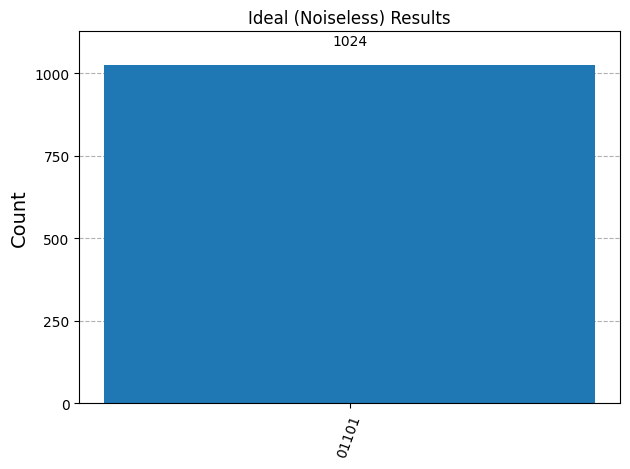

Ideal (Noiseless) counts: {'01101': 1024}


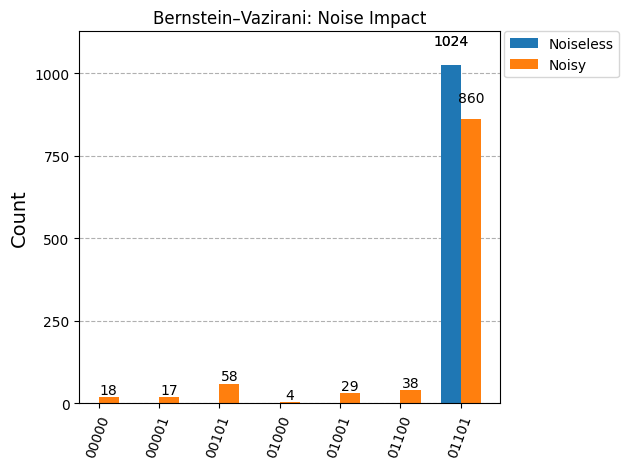

Noisy counts: {'00001': 17, '00000': 18, '00101': 58, '01101': 860, '01000': 4, '01001': 29, '01100': 38}

Secret string: 10110
Correct measurement probability (ideal): 0.00
Correct measurement probability (noisy): 0.00
Fidelity loss due to noise: 100.00%


In [9]:
def bernstein_vazirani_circuit(s):
    n = len(s)
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)
    qc.h(range(n + 1))
    for i, bit in enumerate(s):
        if bit == '1':
            qc.cx(i, n)
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

s = '10110'
qc = bernstein_vazirani_circuit(s)

ideal_sim = AerSimulator()
tqc_ideal = transpile(qc, ideal_sim)
job_ideal = ideal_sim.run(tqc_ideal, shots=1024)
res_ideal = job_ideal.result()
counts_ideal = res_ideal.get_counts()

display(plot_histogram(counts_ideal, title="Ideal (Noiseless) Results"))
print("Ideal (Noiseless) counts:", counts_ideal)

# add noise
noise_model = NoiseModel()

p_gate = 0.02
p_cx = 0.05
t1 = 50e3
t2 = 70e3
gate_time = 50

depol1 = depolarizing_error(p_gate, 1)
depol2 = depolarizing_error(p_cx, 2)


noise_model.add_all_qubit_quantum_error(depol1, ['u1', 'u2', 'u3', 'id'])
noise_model.add_all_qubit_quantum_error(depol2, ['cx'])

relax_error = thermal_relaxation_error(t1, t2, gate_time)
noise_model.add_all_qubit_quantum_error(relax_error, ['u1', 'u2', 'u3'])

noisy_sim = AerSimulator(noise_model=noise_model)
tqc_noisy = transpile(qc, noisy_sim)
job_noisy = noisy_sim.run(tqc_noisy, shots=1024)
res_noisy = job_noisy.result()
counts_noisy = res_noisy.get_counts()

display(plot_histogram([counts_ideal, counts_noisy],
                       legend=['Noiseless', 'Noisy'],
                       title="Bernstein–Vazirani: Noise Impact"))

print("Noisy counts:", counts_noisy)

correct_str = s
p_correct_noiseless = counts_ideal.get(correct_str, 0) / 1024
p_correct_noisy = counts_noisy.get(correct_str, 0) / 1024

print(f"\nSecret string: {s}")
print(f"Correct measurement probability (ideal): {p_correct_noiseless:.2f}")
print(f"Correct measurement probability (noisy): {p_correct_noisy:.2f}")
print(f"Fidelity loss due to noise: {(1 - p_correct_noisy):.2%}")


In [10]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def bv_oracle(qc, inputs, ancilla, s):
    for i, bit in enumerate(s):
        if bit == '1':
            qc.cx(inputs[i], ancilla)

def bernstein_vazirani_circuit(s):
    n = len(s)
    qreg = QuantumRegister(n + 1, 'q')
    creg = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(qreg, creg)
    inputs = list(range(n))
    ancilla = n

    qc.x(ancilla)
    qc.h(qreg)
    bv_oracle(qc, inputs, ancilla, s)
    qc.h(inputs)
    qc.measure(inputs, creg)
    return qc

def run_bv(qc):
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=1024).result()
    counts = result.get_counts()
    plot_histogram(counts)
    plt.show()
    print("Measurement results:", counts)
    print("Most frequent bitstring:", max(counts, key=counts.get))

s = '1011'
qc = bernstein_vazirani_circuit(s)
print(qc.draw('text'))

run_bv(qc)

     ┌───┐          ┌───┐          ┌─┐           
q_0: ┤ H ├───────■──┤ H ├──────────┤M├───────────
     ├───┤┌───┐  │  └┬─┬┘          └╥┘           
q_1: ┤ H ├┤ H ├──┼───┤M├────────────╫────────────
     ├───┤└───┘  │   └╥┘      ┌───┐ ║      ┌─┐   
q_2: ┤ H ├───────┼────╫────■──┤ H ├─╫──────┤M├───
     ├───┤       │    ║    │  └───┘ ║ ┌───┐└╥┘┌─┐
q_3: ┤ H ├───────┼────╫────┼────■───╫─┤ H ├─╫─┤M├
     ├───┤┌───┐┌─┴─┐  ║  ┌─┴─┐┌─┴─┐ ║ └───┘ ║ └╥┘
q_4: ┤ X ├┤ H ├┤ X ├──╫──┤ X ├┤ X ├─╫───────╫──╫─
     └───┘└───┘└───┘  ║  └───┘└───┘ ║       ║  ║ 
c: 4/═════════════════╩═════════════╩═══════╩══╩═
                      1             0       2  3 
Measurement results: {'1101': 1024}
Most frequent bitstring: 1101
